<a href="https://colab.research.google.com/github/InstituteOfAnalyticsUSA/healthcare/blob/main/User_based_sparse_matrix_approach_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##About the dataset (UCI ML Drug Review dataset)

The Kaggle UCI ML Drug Review dataset contains a collection of drug reviews and ratings for various drugs. It includes more than 200,000 drug reviews from over 3,000 drugs, which are divided into 10 categories based on their therapeutic effect.

* **uniqueID** - the number of unique user of the drug.

* **drugName** - the name of the drug being reviewed.

* **condition** - the condition for which the drug is used to treat.

* **review** - the text of the review written by the patient.

* **rating** - the rating given by the patient on a scale of 1 to 10.

* **date** - the date when the review was written.

* **usefulCount** - the number of users who found the review useful.

<a id="lib"></a>
# 1. Import Libraries

**Let us import the required libraries.**

In [ ]:
###############
## Libraries ##
###############

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

%matplotlib inline
# # display all columns of the dataframe
# pd.options.display.max_columns = None

# # display all rows of the dataframe
# pd.options.display.max_rows = None

# to display the float values upto 6 decimal places
pd.options.display.float_format = '{:.6f}'.format
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')
# set the plot size using 'rcParams'
# once the plot size is set using 'rcParams', it sets the size of all the forthcoming plots in the file
# pass width and height in inches to 'figure.figsize'
plt.rcParams['figure.figsize'] = [15,8]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/UCI_ML_DRUG/drugsComTrain_raw_and_Test_raw/

/content/drive/MyDrive/UCI_ML_DRUG/drugsComTrain_raw_and_Test_raw


In [ ]:
!pwd

/content/drive/MyDrive/UCI_ML_DRUG/drugsComTrain_raw_and_Test_raw


<a id="prep"></a>
# 2. Data Preparation

<a id="read"></a>
## 2.1 Read the Data

#### Read the dataset and print the first five observations.

In [ ]:
# load the csv file
# store the data in 'df'
df = pd.read_csv('drugsComTrain_raw.csv')

# display first five observations using head()
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


**Let us now see the number of variables and observations in the data.**

In [ ]:
# use 'shape' to check the dimension of data
df.shape

(161297, 7)

**Interpretation:** The data has 161297 observations and 7 columns.

<a id="dtype"></a>
## 2.2 Check the Data Type

**Check the data type of each variable. If the data type is not as per the data definition, change the data type.**

In [ ]:
# use 'dtypes' to check the data type of a variable
df.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

**Interpretation:** All the variables are of correct data types, so no need to change data type of any variable.

<a id="null"></a>
## 2.3 Missing Value Treatment

First run a check for the presence of missing values and their percentage for each column. Then choose the right approach to treat them.

In [ ]:
###############################
##   Checking for missings   ##
###############################

## Making a dataset limited to vars of interest
fullset = df.copy()

## Check for any NA/NaN values
if fullset.isnull().values.any() == True:
    print("\nThere are ", fullset.isnull().sum().sum(), " missing values in the dataset") # number missings
    print("\nThe columns that have NA/NaN are: ", fullset.columns[fullset.isna().any()].tolist()) # location missings
elif fullset.isnull().values.any() == False:
    print("\nThere are no missing values in the dataset") # number missings

## This will set all missings=0, only being used here as an example
## Data cleaning should be done prior to this last check
fullset.head()


There are  899  missing values in the dataset

The columns that have NA/NaN are:  ['condition']


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


We will now determine the percentage of null values present in each column, provided there are any null values in that column.

In [ ]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df.isnull().sum().sort_values(ascending=False)

# calculate percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)

# concat the 'Total' and 'Percent' columns using 'concat' function
# pass a list of column names in parameter 'keys'
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_data

,Total,Percentage of Missing Values
condition,899,0.557357
uniqueID,0,0.000000
drugName,0,0.000000
review,0,0.000000
rating,0,0.000000
date,0,0.000000
usefulCount,0,0.000000


Based on the above analysis, we can observe that the `condition` column contains only 0.56% null values. As we don't have any reliable information to impute those null values, we have decided to drop them.

In [ ]:
# To drop the null values, we are using the .dropna() function of the dataframe.
# This function drops any row that contains null values. By setting the parameter inplace=True,
# the modifications are made in the existing dataframe.

df.dropna(inplace=True)

In [ ]:
# final checking for null values.
# We can see there are no null values now.

df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
# shape of the dataframe after dropping the null values
df.shape

(160398, 7)

In [ ]:
## all the distinct conditions
set(df['condition'].values)

{'0</span> users found this comment helpful.',
 '10</span> users found this comment helpful.',
 '110</span> users found this comment helpful.',
 '11</span> users found this comment helpful.',
 '121</span> users found this comment helpful.',
 '123</span> users found this comment helpful.',
 '12</span> users found this comment helpful.',
 '13</span> users found this comment helpful.',
 '142</span> users found this comment helpful.',
 '145</span> users found this comment helpful.',
 '146</span> users found this comment helpful.',
 '14</span> users found this comment helpful.',
 '15</span> users found this comment helpful.',
 '16</span> users found this comment helpful.',
 '17</span> users found this comment helpful.',
 '18</span> users found this comment helpful.',
 '19</span> users found this comment helpful.',
 '1</span> users found this comment helpful.',
 '20</span> users found this comment helpful.',
 '21</span> users found this comment helpful.',
 '22</span> users found this comment

We are going to remove all the conditions which says `users found this comment helpful.`

In [ ]:
# remove unwanted text from the 'condition' column
df['condition'] = df['condition'].str.replace(r'\d+</span> users found this comment helpful\.', '', regex=True)

In [ ]:
# after replacing the unwanted text to a empty string ('') from the condition column.
# now, we are ommiting the observations in which the condition is just empty string ('')

df = df[df['condition'] != ''].reset_index(drop=True)

In [ ]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
df.shape

(159498, 7)

Now, we are going to see how many distinct `drugName`, `condition` are there in the dataset.

In [ ]:
df['drugName'].nunique(), df['condition'].nunique()

(3412, 811)

**Interpretation:** From the above we can see that, we can observe that out of 159,498 unique observations or patients, there are only 3,412 drugs, and a total of 811 distinct health conditions or `conditions.`

Let's have a into the distribution of the `rating` column.

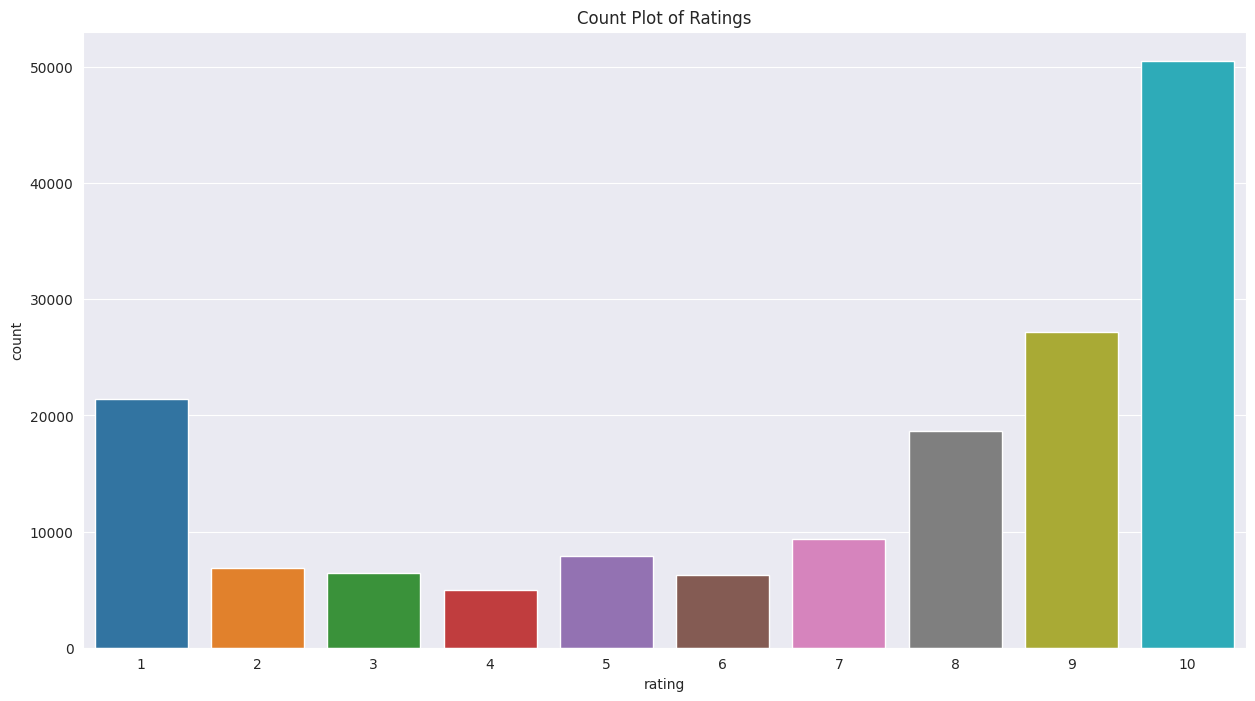

In [ ]:
# Create a count plot of the values
sns.countplot(x=df['rating'])

# Set the title of the plot
plt.title('Count Plot of Ratings')

# Display the plot
plt.show()

In [ ]:
# mean rating
df['rating'].mean()

6.99714729965266

In [ ]:
# descriptive statistics on the rating column
df['rating'].describe()

count   159498.000000
mean         6.997147
std          3.272517
min          1.000000
25%          5.000000
50%          8.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

Interpretations on the above descriptive statistics:

* **Count:** 159,498 observations or data points in the dataset.

* **Mean:** The average value of the dataset is 6.997147, which indicates that the dataset is skewed towards lower values.

* **Std:** The standard deviation of the dataset is 3.272517, which means that there is a moderate amount of variability in the data.

* **Min:** The minimum value in the dataset is 1.000000, which represents the lowest possible value in the dataset.

* **25%:** The 25th percentile of the dataset is 5.000000, which indicates that 25% of the data points in the dataset are lower than 5.000000.

* **50%:** The 50th percentile of the dataset is 8.000000, which represents the median value of the dataset. This indicates that 50% of the data points in the dataset are lower than 8.000000 and 50% are higher than 8.000000.

* **75%:** The 75th percentile of the dataset is 10.000000, which indicates that 75% of the data points in the dataset are lower than 10.000000.

* **Max:** The maximum value in the dataset is 10.000000, which represents the highest possible value in the dataset.

Based on these numbers, we can infer that the dataset has a wide range of values, but is skewed towards lower values, and the majority of the data points fall within the range of 5 to 10. Additionally, there are no outliers in the dataset, as the minimum and maximum values are within a reasonable range.

<a id="lib"></a>
# 3. User-Based Collaborative Filtering (CF)

Collaborative filtering is a technique used in recommendation systems to predict a user's preferences for items based on the preferences of other similar users. It is based on the idea that people who have similar preferences in the past are likely to have similar preferences in the future.

Collaborative filtering algorithms typically use a user-item matrix, where the rows represent users, the columns represent items, and the entries in the matrix represent the user's ratings for the items. The algorithm then uses this matrix to find other users who have similar preferences and recommends items that those users have rated highly but the user has not yet seen.

Due to memory restrictions in the colab we are going to consider the smaller subset of the main dataset and continue our analysis.

In [ ]:
## main dataset
df.head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17


In [ ]:
# considering the subset of the main data
data = df.sample(frac=0.15, random_state=47).reset_index(drop=True)

In [ ]:
# shape of the smaller dataset
data.shape

(23925, 7)

In [ ]:
# Now, see number of unique drugs and conditions
data['drugName'].nunique(), data['condition'].nunique()

(2017, 567)

In [ ]:
# head of the data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,7191,Aluminum chloride hexahydrate,Hyperhidrosis,"""By far, THE single biggest boost to my self-e...",10,10-Aug-11,7
1,13617,Amphetamine / dextroamphetamine,Narcolepsy,"""I am a 69 year old female who has been diagno...",10,25-Jul-12,75
2,1408,Sumatriptan,Cluster Headaches,"""Did not work for chronic cluster headache at ...",1,6-Sep-09,14
3,189399,Oxycodone,Chronic Pain,"""Quick to act, seems to also help with depress...",10,27-Aug-12,96
4,152411,Ciprofloxacin,Urinary Tract Infection,"""I was put on a dose of 1000 mg a day. Took c...",6,6-Mar-13,62


Let's make a pivot table in which the columns are `drugName` index are `uniqueID` and the values are `rating` to make user-based CF recommender system.

In [ ]:
# pivot table for user-based CF
pivot_data = data.pivot(index='uniqueID', columns='drugName', values='rating').fillna(0)

In [ ]:
## read the head
pivot_data.head()

drugName,A / B Otic,Abacavir / dolutegravir / lamivudine,Abilify,AbobotulinumtoxinA,Abreva,Acamprosate,Acanya,Accutane,Acetaminophen,Acetaminophen / aspirin / caffeine,...,Zyban,Zyclara,Zyprexa,Zyprexa Intramuscular,Zyprexa Zydis,Zyrtec,Zyrtec-D,Zyrtec-D 12 Hour,Zyvox,ella
uniqueID,,,,,,,,,,,,,,,,,,,,,
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# shape of the pivot table (pivot data)
pivot_data.shape

(23925, 2017)

The shape displayed above reveals that there exist 23,925 distinct users with 2,017 different drug names. Essentially, this represents a user-item matrix where the ratings are the values assigned.

In [ ]:
# let convert the pivot_data dataframe to matrix
# and reset the datatype to int8 to save memory

pivot_matrix = pivot_data.values
pivot_matrix = pivot_matrix.astype('int8')

In [ ]:
len(pivot_matrix[0])

2017

In [ ]:
#pivot_matrix = pd.pivot_table(pivot_data, index='user_id', columns='item_id', values='rating')

In [ ]:
len(pivot_matrix)

23925

In [ ]:
len(pivot_matrix[0])

2017

In [ ]:
pivot_matrix.shape

(23925, 2017)

In [ ]:
type(pivot_matrix)

numpy.ndarray

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
pivot_matrix = csr_matrix(pivot_matrix)

In [ ]:
type(pivot_matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
# !pip3 install sklearn
# import sklearn

In [ ]:
# !pip3 install --upgrade sklearn

In [ ]:


# find the similarity matrix using liner kernel,
# which will give the similarity amoung the two users
# if the similarity value is high then they are more similar and vice-versa.
# here the similarity are nothing-but dot product between vectors.



#similarity_matrix_lk = linear_kernel(pivot_matrix)
import numpy as np
import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels


In [ ]:
#pivot_matrix = pd.pivot_table(df, index='user_id', columns='item_id', values='rating')

In [ ]:
#from itertools import pairwise
# prompt: >>> import numpy as np >>> from sklearn.metrics import pairwise_distances >>> from sklearn.metrics.pairwise import pairwise_kernels

#from sklearn.metrics.pairwise import pairwise_kernel

#from itertools import pairwise
# prompt: >>> import numpy as np >>> from sklearn.metrics import pairwise_distances >>> from sklearn.metrics.pairwise import pairwise_kernels

#from sklearn.metrics.pairwise import pairwise_kernel

similarity_matrix_lk = sklearn.metrics.pairwise.pairwise_kernels(pivot_matrix)


In [ ]:
# similarity matrix
len(similarity_matrix_lk)

23925

In [ ]:
similarity_matrix_lk.shape

(23925, 23925)

In [ ]:
# let's store all these similarity score to a dataframe
# where the columns and index are the uniqueID (users)
similarity_df_lk = pd.DataFrame(data=similarity_matrix_lk,
                             index=pivot_data.index,
                             columns=pivot_data.index)

In [ ]:
# head the head
similarity_df_lk.head()

uniqueID,4,7,35,41,45,46,52,58,60,61,...,232185,232194,232209,232217,232220,232226,232229,232232,232239,232283
uniqueID,,,,,,,,,,,,,,,,,,,,,
4,81.000000,45.000000,9.000000,90.000000,45.000000,81.000000,90.000000,9.000000,45.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,45.000000,25.000000,5.000000,50.000000,25.000000,45.000000,50.000000,5.000000,25.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35,9.000000,5.000000,1.000000,10.000000,5.000000,9.000000,10.000000,1.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41,90.000000,50.000000,10.000000,100.000000,50.000000,90.000000,100.000000,10.000000,50.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,45.000000,25.000000,5.000000,50.000000,25.000000,45.000000,50.000000,5.000000,25.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In this, we will create a user-based collaborative filtering recommender system that identifies similar users based on their high ratings for specific drugs. It's important to note that each user in this system has only provided a single rating, indicating that they have only used one drug in their lifetime. Therefore, we will only consider users who have given high ratings for a particular drug, as they are more likely to have similar preferences.

In [ ]:

# this function will recommends the similar to the given user
def similar_user_recommendation(user_id):

    # check if the given user in the sample data
    if user_id not in pivot_data.index:
      print('Invalid user!')
      return

    # get rating given by the user
    r = int(data[data['uniqueID'] == user_id]['rating'].values)

    # only interested in the ratings which are greater than or equal to 7
    if r < 7:
      # we are not interest to find similar user who have given less 7 rating to a drug.
      print('This user have given less than 7 rating to the drug!')
      return

    # Now, let's find out the similar to the given user who have given ratings
    # greater than or equal to 7

    indx = similarity_df_lk[user_id].index
    values = similarity_df_lk[user_id].values

    dff = pd.DataFrame(columns=['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'])

    for i, v in zip(indx, values):

      # only interested on the similar user whose rating is greater than 7
      rating_by_similar_user = int(data[data['uniqueID'] == i]['rating'].values)

      if v >= 49 and rating_by_similar_user >= 7:
        X = data[data['uniqueID'] == i]
        dff = pd.concat([dff, X], axis=0)

    return dff

In [ ]:
## all the valid user-ids
list(similarity_df_lk.index.values)

[4,
 7,
 35,
 41,
 45,
 46,
 52,
 58,
 60,
 61,
 67,
 103,
 110,
 111,
 114,
 148,
 160,
 162,
 193,
 218,
 226,
 231,
 237,
 258,
 272,
 275,
 278,
 279,
 301,
 304,
 315,
 316,
 325,
 330,
 347,
 354,
 371,
 373,
 406,
 416,
 420,
 430,
 440,
 448,
 458,
 461,
 483,
 492,
 496,
 504,
 507,
 508,
 531,
 538,
 550,
 560,
 569,
 575,
 595,
 614,
 623,
 636,
 637,
 639,
 640,
 645,
 646,
 651,
 656,
 661,
 678,
 682,
 689,
 693,
 696,
 724,
 733,
 751,
 757,
 767,
 795,
 806,
 835,
 843,
 844,
 878,
 881,
 917,
 918,
 919,
 927,
 936,
 942,
 944,
 948,
 952,
 956,
 963,
 967,
 972,
 993,
 1009,
 1012,
 1018,
 1022,
 1026,
 1030,
 1032,
 1048,
 1049,
 1055,
 1058,
 1059,
 1060,
 1068,
 1083,
 1084,
 1085,
 1086,
 1088,
 1091,
 1092,
 1113,
 1120,
 1128,
 1130,
 1133,
 1141,
 1147,
 1160,
 1170,
 1182,
 1203,
 1218,
 1237,
 1238,
 1239,
 1250,
 1256,
 1264,
 1270,
 1274,
 1292,
 1298,
 1300,
 1317,
 1322,
 1324,
 1329,
 1350,
 1351,
 1356,
 1359,
 1375,
 1382,
 1387,
 1408,
 1412,
 1432,
 

In [ ]:
similar_user_recommendation(4)

,uniqueID,drugName,condition,review,rating,date,usefulCount
19854,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
16642,41,Medroxyprogesterone,Birth Control,"""I used the depo injection for 10 years and lo...",10,15-Nov-15,6
14418,46,Medroxyprogesterone,Birth Control,"""I&#039;ve taken 2 shots so far and overall ha...",9,13-Nov-15,4
14150,52,Medroxyprogesterone,Birth Control,"""I have had nothing but a great experience on ...",10,5-Jan-16,5
7630,193,Medroxyprogesterone,Birth Control,"""I was on the depo shot for about a year. I lo...",8,24-Aug-15,3
12203,258,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I thought the shot would be easy due to the f...",7,5-Nov-14,92
21621,304,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Have been on Depo-Provera almost 3 years sinc...",10,30-Jan-15,33
10143,315,Medroxyprogesterone,Birth Control,"""Everyone I talk to seems to have had differen...",10,2-Jan-15,47
4098,330,Medroxyprogesterone,Birth Control,"""Been on this birth control for 17yrs now and ...",9,30-Jun-13,13
19272,354,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;ve been on this shot for a little more...",8,24-Apr-15,20
